In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [15]:
img_width, img_height = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2  
)

data_dir = '/kaggle/input/dog-emotions-prediction' 

In [16]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary', 
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary', 
    subset='validation'
)

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x) 
predictions = Dense(1, activation='sigmoid')(x) 

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

Found 12737 images belonging to 1 classes.
Found 3184 images belonging to 1 classes.


In [17]:
for layer in base_model.layers:
    layer.trainable = False


optimizer = Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs
)

Epoch 1/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 268s 602ms/step - accuracy: 0.6627 - loss: 0.6762 - val_accuracy: 1.0000 - val_loss: 0.6171
Epoch 2/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 0.6189 - val_accuracy: 1.0000 - val_loss: 0.6169
Epoch 3/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 216s 536ms/step - accuracy: 0.9965 - loss: 0.5971 - val_accuracy: 1.0000 - val_loss: 0.5455
Epoch 4/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 1.0000 - loss: 0.5297 - val_accuracy: 1.0000 - val_loss: 0.5453
Epoch 5/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 260s 531ms/step - accuracy: 1.0000 - loss: 0.5275 - val_accuracy: 1.0000 - val_loss: 0.4844
Epoch 6/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 1.0000 - loss: 0.4641 - val_accuracy: 1.0000 - val_loss: 0.4843
Epoch 7/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 211s 522ms/step - accuracy: 1.0000 - loss: 0.4682 - val_accuracy: 1.0000 - val_loss: 0.4354
Epoch 8/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 1.0000 - loss: 0.4

In [18]:
for layer in base_model.layers[-10:]:  
    layer.trainable = True


optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    
    
def scheduler(epoch, learning_rate):
    min_lr = 1e-6  
    decay_rate = 0.9  
    if epoch < 10:
        return learning_rate
    else:
        new_lr = learning_rate * decay_rate
        return max(new_lr, min_lr)  

lr_scheduler = LearningRateScheduler(scheduler)


fine_tune_epochs = 15


history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=fine_tune_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 263s 653ms/step - accuracy: 0.8234 - loss: 0.4010 - val_accuracy: 1.0000 - val_loss: 0.0561 - learning_rate: 1.0000e-05
Epoch 2/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 1.0000 - loss: 0.0365 - val_accuracy: 1.0000 - val_loss: 0.0556 - learning_rate: 1.0000e-05
Epoch 3/15


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


398/398 ━━━━━━━━━━━━━━━━━━━━ 232s 574ms/step - accuracy: 1.0000 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0051 - learning_rate: 1.0000e-05
Epoch 4/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0050 - learning_rate: 1.0000e-05
Epoch 5/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 228s 566ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 0.0017 - learning_rate: 1.0000e-05
Epoch 6/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0017 - learning_rate: 1.0000e-05
Epoch 7/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 230s 571ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 8.6894e-04 - learning_rate: 1.0000e-05
Epoch 8/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 8.7030e-04 - learning_rate: 1.0000e-05
Epoch 9/15
398/398 ━━━━━━━━━━━━━━━━━━━━ 230s 571m

In [22]:
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


model.save('dog_emotion_model.h5')

plt.figure(figsize=(12, 4))


if 'history' in locals():
    acc = history.history['accuracy'] + history_fine_tune.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
    loss = history.history['loss'] + history_fine_tune.history['loss']
    val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']
else:
    # If only fine-tuning is present
    acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']
    loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']

epochs_range = range(len(acc))



100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 447ms/step - accuracy: 1.0000 - loss: 1.6543e-04
Validation Accuracy: 100.00%


<Figure size 1200x400 with 0 Axes>

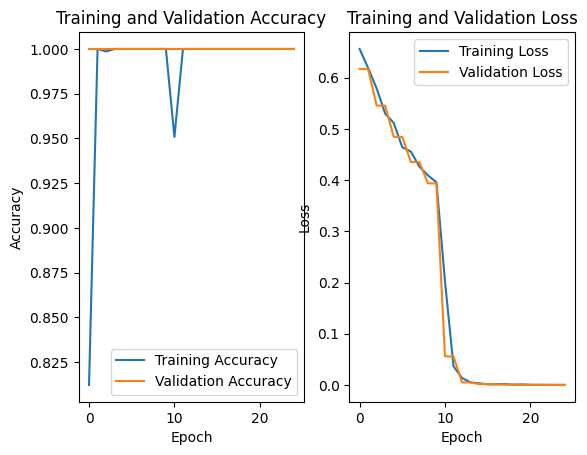

In [23]:
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Displaying images for category: angry


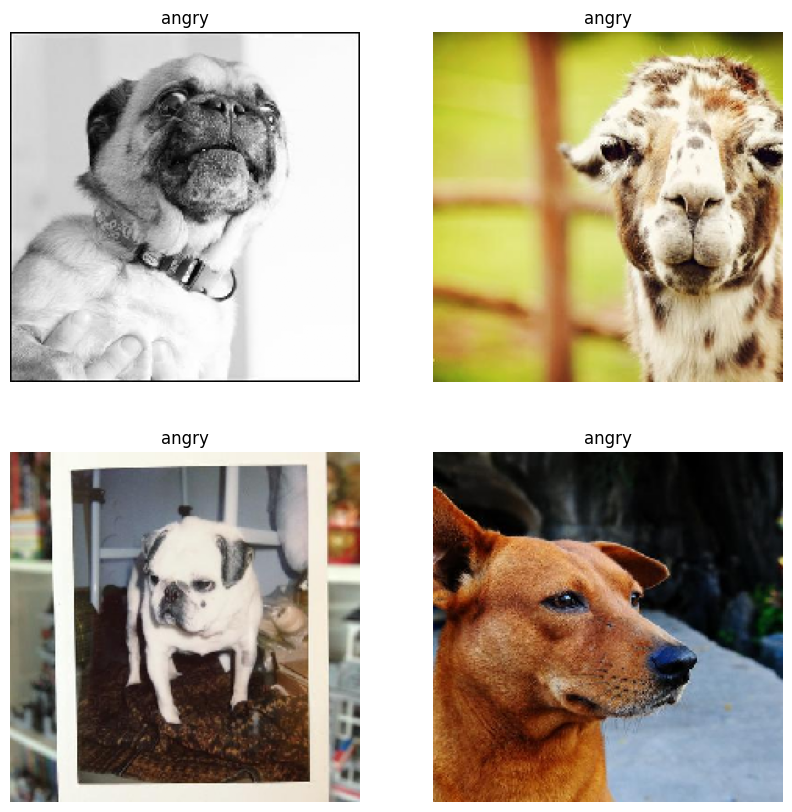

Displaying images for category: happy


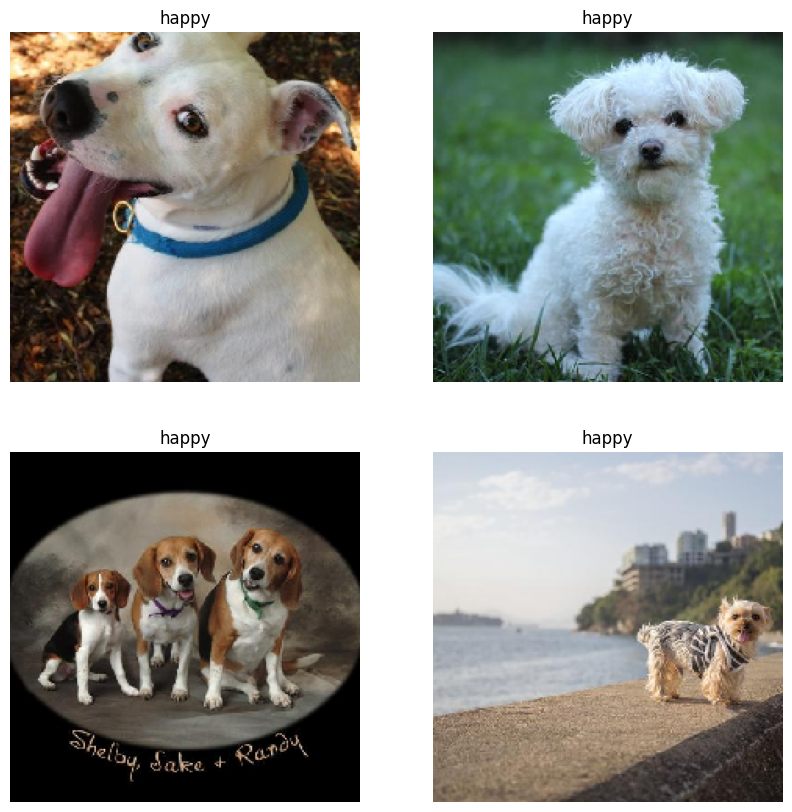

Displaying images for category: relaxed


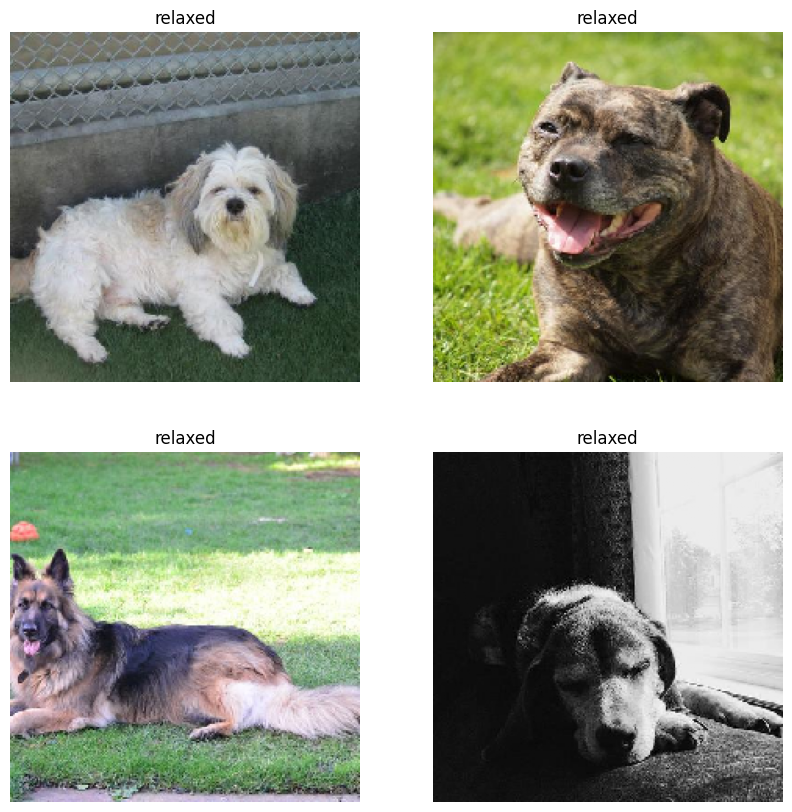

Displaying images for category: sad


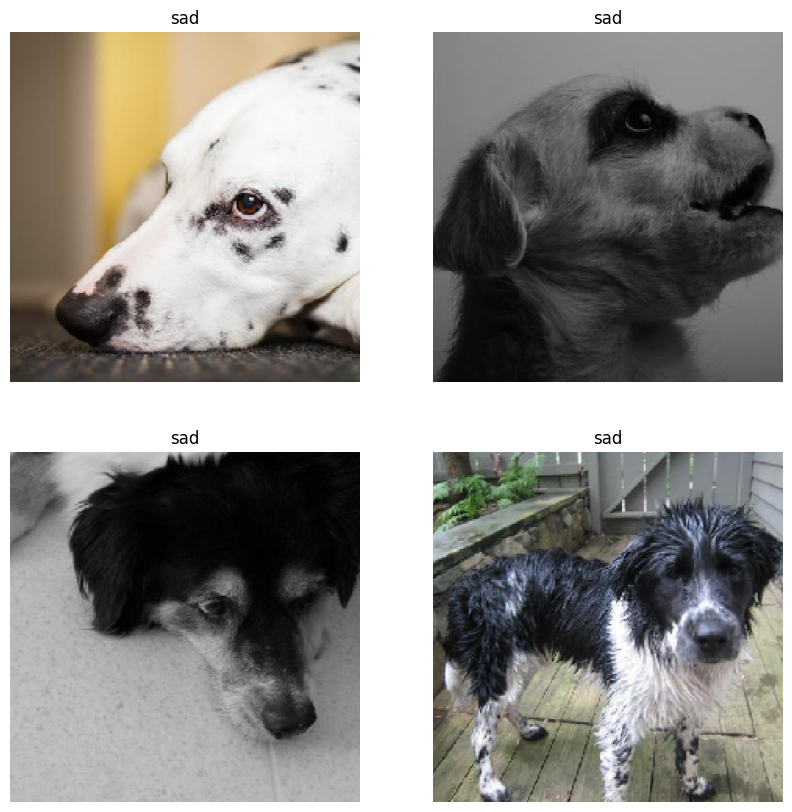

In [32]:
categories = ['angry', 'happy', 'relaxed', 'sad']


def display_images(category, num_images=4):
    plt.figure(figsize=(10, 10))
    folder = os.path.join(dataset_dir, category)
    images = os.listdir(folder)
    
    for i in range(num_images):
        img_path = os.path.join(folder, random.choice(images))
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        
        plt.subplot(2, 2, i+1)
        plt.imshow(img_array)
        plt.title(f"{category}")
        plt.axis('off')
    
    plt.show()


for category in categories:
    print(f"Displaying images for category: {category}")
    display_images(category, num_images=4)